In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

### **LOADING THE DATASET**

In [ ]:
import numpy as np

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):

      h5images = h5py.File(path[0],'r')
      h5masks = h5py.File(path[1],'r')
      self.images = h5images.get(f'{list(h5images.keys())[0]}')
      self.oldmasks = h5masks.get(f'{list(h5masks.keys())[0]}')
      self.labels = np.load(path[2], allow_pickle=True)
      self.bboxes = np.load(path[3], allow_pickle=True)
      j = 0
      m=[]
      for i in range(len(self.labels)):
        m.append(self.oldmasks[j:j+len(self.labels[i])])
        j = j + len(self.labels[i])
      self.masks=np.array(m)

    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):

      transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
      img = torch.tensor(self.images[index].astype(float)).unsqueeze(0)
      imgnew = transform(F.interpolate(img, size=(800, 1066), mode='nearest').squeeze(0))
      imgnew = F.pad(imgnew, (11,11), 'constant', 0) 
      label = torch.tensor(self.labels[index]) 

      masknew = torch.tensor(self.masks[index].astype(float)).unsqueeze(0)
      masknew = F.interpolate(masknew, size=(800, 1066), mode='nearest').squeeze(0)
      masknew = F.pad(masknew, (11,11), 'constant', 0)

      bbox1 = np.copy(self.bboxes[index])
      bbox1[:, 0] = bbox1[:, 0] * (800/300)
      bbox1[:, 1] = bbox1[:, 1] * (1066/400) + 11
      bbox1[:, 2] = bbox1[:, 2] * (800/300)        
      bbox1[:, 3] = bbox1[:, 3] *(1066/400) + 11        
      bbox1 = torch.tensor(bbox1).squeeze(0)

      return imgnew, label, masknew, bbox1,index

In [ ]:
class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    def collect_fn(self, batch):

        transed_img_list = []
        label_list = []
        transed_mask_list = []
        transed_bbox_list = []
        index_list=[]
        for transed_img, label, transed_mask, transed_bbox,index in batch:
            transed_img_list.append(transed_img.unsqueeze(0))
            label_list.append(label)
            transed_mask_list.append(transed_mask)
            transed_bbox_list.append(transed_bbox)
            index_list.append(index)
        return transed_img_list, label_list, transed_mask_list, transed_bbox_list,index_list


    def loader(self):
        return DataLoader(dataset=self.dataset,
                      batch_size=self.batch_size,
                      shuffle=self.shuffle,
                      collate_fn=self.collect_fn, 
                      num_workers = self.num_workers,drop_last=True)

In [ ]:
Dataset = BuildDataset(paths)
batch_size = 1
build_loader = BuildDataLoader(Dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader = build_loader.loader()
print(len(dataloader))

3265


**VISUAL CORRECTNESS**

<Figure size 432x288 with 0 Axes>

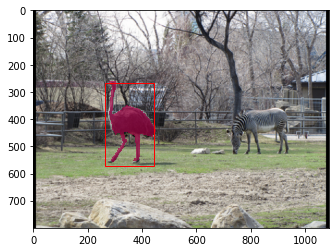

<Figure size 432x288 with 0 Axes>

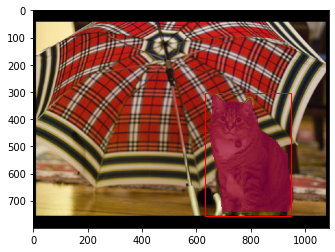

<Figure size 432x288 with 0 Axes>

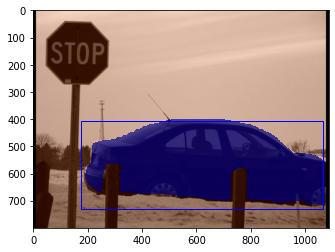

In [ ]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches
from PIL import Image
k=0
mask_color_list = ["jet", "ocean","Spectral"]
bbox_color=['b','g','r']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for iter, data in enumerate(dataloader, 0):

    img, label, mask, bbox,index = [data[i] for i in range(len(data))]

    plt.figure()
    for i in range(batch_size):

      fig,ax = plt.subplots(1)
      opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
      img_plot = opp_transform(img[i].squeeze(0))
      plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))
      if (len(mask[i])>1):
        m1=mask[i][0]
        m2=mask[i][1]
        m1 = np.reshape(m1,(800,1088,1))
        maskedm1 = np.ma.masked_where(m1 == 0, m1)
        maskedm1=np.squeeze(maskedm1)
        plt.imshow(maskedm1, cmap=mask_color_list[label[i][0].item()-1], alpha=0.7)
        m2 = np.reshape(m2,(800,1088,1))
        maskedm2 = np.ma.masked_where(m2 == 0, m2)
        maskedm2=np.squeeze(maskedm2)
        plt.imshow(maskedm2, cmap=mask_color_list[label[i][1].item()-1], alpha=0.7)
        rect1 = patches.Rectangle((bbox[i][0][0],bbox[i][0][1]),(bbox[i][0][2]-bbox[i][0][0]),(bbox[i][0][3]-bbox[i][0][1]),linewidth=1,edgecolor=bbox_color[label[i][0].item()-1],facecolor='none')
        ax.add_patch(rect1)
        rect1 = patches.Rectangle((bbox[i][1][0],bbox[i][1][1]),(bbox[i][1][2]-bbox[i][1][0]),(bbox[i][1][3]-bbox[i][1][1]),linewidth=1,edgecolor=bbox_color[label[i][1].item()-1],facecolor='none')
        ax.add_patch(rect1)
      else: 
        mask[i] = np.reshape(mask[i],(800,1088,len(mask[i])))
        masked = np.ma.masked_where(mask[i] == 0, mask[i])
        masked=np.squeeze(masked)
        plt.imshow(masked, cmap=mask_color_list[label[i].item()-1], alpha=0.7)
        rect1 = patches.Rectangle((bbox[i][0],bbox[i][1]),(bbox[i][2]-bbox[i][0]),(bbox[i][3]-bbox[i][1]),linewidth=1,edgecolor=bbox_color[label[i].item()-1],facecolor='none')
        ax.add_patch(rect1) 
      k=k+1
      plt.show()

    if iter == 2:
      break
  

**HISTOGRAMS**

In [ ]:
bboxes = np.load(paths[3], allow_pickle=True)
for i in range(len(bboxes_1)):
  if len(bboxes[i])> 1:

    bboxes[i][0][0]=bboxes[i][0][0]* (800/300)
    bboxes[i][0][1]=bboxes[i][0][1]* (1066/400) + 11
    bboxes[i][0][2]=bboxes[i][0][2]* (800/300)   
    bboxes[i][0][3]=bboxes[i][0][3] *(1066/400) + 11 
    bboxes[i][1][0]=bboxes[i][1][0]* (800/300)
    bboxes[i][1][1]=bboxes[i][1][1]* (1066/400) + 11
    bboxes[i][1][2]=bboxes[i][1][2]* (800/300)   
    bboxes[i][1][3]=bboxes[i][1][3] *(1066/400) + 11 
  else:
    bboxes[i]=bboxes[i].squeeze(0)

    bboxes[i][0]=bboxes[i][0]* 2.67
    bboxes[i][1]=bboxes[i][1]* 2.665 + 11
    bboxes[i][2]=bboxes[i][2]* 2.67   
    bboxes[i][3]=bboxes[i][3] * 2.665 + 11 

In [ ]:
bboxes_h=[]
bboxes_w=[]

for i in range(len(bboxes)):
  if (len(bboxes[i])==2):

    bboxes_w.append(bboxes[i][0][2]-bboxes[i][0][0])
    bboxes_h.append(bboxes[i][0][3]-bboxes[i][0][1])
    bboxes_w.append(bboxes[i][1][2]-bboxes[i][1][0])
    bboxes_h.append(bboxes[i][1][3]-bboxes[i][1][1])


  else:

    bboxes_w.append(bboxes[i][0][2]-bboxes[i][0][0])
    bboxes_h.append(bboxes[i][0][3]-bboxes[i][0][1])



In [ ]:
aspect=np.asarray(bboxes_w)/np.asarray(bboxes_h)
scale=(np.asarray(bboxes_h)*np.asarray(bboxes_w))**0.5


[0.71042067]


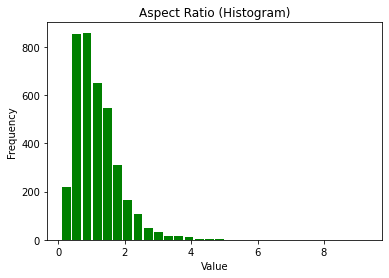

In [ ]:
y,x,_=plt.hist(x=aspect,color ='green', bins=30, rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Aspect Ratio (Histogram)')
print( x[np.where(y == y.max())])

[254.22453]


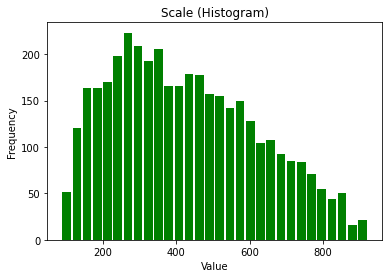

In [ ]:
y,x,_=plt.hist(x=scale,color ='green',bins=30,  rwidth=0.85)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Scale (Histogram)')
print( x[np.where(y == y.max())])

In [ ]:
def IOU(bbox_1 ,bbox_2):
  x_1up=bbox_1[0]
  y_1up=bbox_1[1]
  x_1l=bbox_1[2]
  y_1l=bbox_1[3]

  x_2up=bbox_2[0]
  y_2up=bbox_2[1]
  x_2l=bbox_2[2]
  y_2l=bbox_2[3]

 
  x_up=max(x_1up,x_2up)
  y_up=max(y_1up,y_2up)
  x_l=min(x_1l,x_2l)
  y_l=min(y_1l,y_2l)

  inter_area=max((x_l-x_up+1),0)*max((y_l-y_up+1),0)
  area_box1=(x_1l-x_1up+1)*(y_1l-y_1up+1)
  area_box2=(x_2l-x_2up+1)*(y_2l-y_2up+1)
  union_area=area_box1+area_box2-inter_area
  iou=inter_area/float(union_area)
  return iou

In [ ]:
w=230
h=286
print(w/h)
print((w*h)**0.5)


0.8041958041958042
256.4761197460692


### **ANCHOR BOX GENERATION**

tensor([173.2364, 416.3546, 510.1738, 651.1976])


<Figure size 432x288 with 0 Axes>

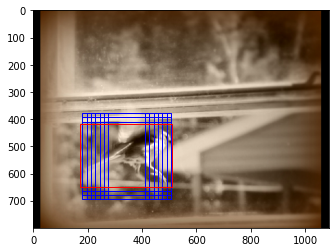

In [ ]:
i=0
for iter, data in enumerate(dataloader, 0):
  img, label, mask, bbox,index = [data[i] for i in range(len(data))]
  bound_box=bbox[i]
  if (i==0):
    break


anchors=np.zeros((50,68,4))
k=0
stride_x= 800/50
stride_y=1088/68

c_y = stride_y*0.5

for i in range(50):
  c_x = stride_x*0.5

  for j in range(68):
    anchors[i][j]=[c_x-w*0.5,c_y-h*0.5,c_x+w*0.5,c_y+h*0.5] 
    c_x += stride_x
  c_y += stride_y


#cross boundary anchors are removed
indicator=np.zeros((50,68))
gt_bboxes=np.zeros((50,68,4))
c=np.zeros((50,68))
d=np.zeros((50,68))
for i in range(50):
  for j in range(68):
    if ((anchors[i][j][0]>=0 and anchors[i][j][1]>=0) and (anchors[i][j][2]<=1088 and anchors[i][j][3]<=800)):
      if (len(bound_box)==2):
        c[i][j]=IOU(anchors[i][j],bound_box[0])
        d[i][j]=IOU(anchors[i][j],bound_box[1]) 
      else:
        c[i][j]=IOU(anchors[i][j],bound_box)

if len(bound_box)==2:
  for i in range(50):
    for j in range(68):
      if (c[i][j]>0.7 or c[i][j]==np.max(c)):
        indicator[i][j]=1
        gt_bboxes[i][j]=bound_box[0]
      elif (d[i][j]>0.7 or d[i][j]==np.max(d)):
        indicator[i][j]=1
        gt_bboxes[i][j]=bound_box[1]
      elif (c[i][j]<0.3 or d[i][j]<0.3):
        indicator[i][j]=0
      else:
        indicator[i][j]=-1
else:
  for i in range(50):
    for j in range(68):
      if (c[i][j]>0.7 or c[i][j]==np.max(c)):
        indicator[i][j]=1
        gt_bboxes[i][j]=bound_box[0]
      elif (c[i][j]<0.3):
        indicator[i][j]=0
      else:
        indicator[i][j]=-1


plt.figure()
for i in range(batch_size):

  fig,ax = plt.subplots(1)
  opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
  img_plot = opp_transform(img[0].squeeze(0))
  plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))
  for j in range(50):
    for k in range(68):
      if (indicator[j][k])==1:
        rect1 = patches.Rectangle((anchors[j][k][0],anchors[j][k][1]),(anchors[j][k][2]-anchors[j][k][0]),(anchors[j][k][3]-anchors[j][k][1]),linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect1)
  if (len(mask[i])>1):
    
    rect1 = patches.Rectangle((bbox[i][0][0],bbox[i][0][1]),(bbox[i][0][2]-bbox[i][0][0]),(bbox[i][0][3]-bbox[i][0][1]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
    rect1 = patches.Rectangle((bbox[i][1][0],bbox[i][1][1]),(bbox[i][1][2]-bbox[i][1][0]),(bbox[i][1][3]-bbox[i][1][1]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
  else:     
    rect1 = patches.Rectangle((bbox[i][0],bbox[i][1]),(bbox[i][2]-bbox[i][0]),(bbox[i][3]-bbox[i][1]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)

  bound_box=bbox[i]
  print(bound_box)
  if i==0:
    break
  plt.show()

### **GROUND TRUTH CREATION**

In [ ]:
# batch_size = 1
# build_loader = BuildDataLoader(Dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# train_loader = build_loader.loader()
# print(len(train_loader))

3265


In [ ]:
print(len(dataloader))
anchor_labels=torch.zeros((len(dataloader),50,68))
anchor_gt_bboxes=torch.zeros((len(dataloader),50,68,4))
anchor_gt_bboxes_p=torch.zeros((len(dataloader),50,68,4))
anchors_all=torch.zeros((len(dataloader),50,68,4))

for iter, data in enumerate(dataloader, 0):
  img, label, mask, bbox,index = [data[i] for i in range(len(data))]
  image=img[0]
  bound_box=bbox[0]
  anchors=np.zeros((50,68,4))
  k=0
  stride_x= 800/50
  stride_y=1088/68

  c_y = stride_y*0.5

  for i in range(50):
    c_x = stride_x*0.5

    for j in range(68):
      anchors[i][j]=[c_x-w*0.5,c_y-h*0.5,c_x+w*0.5,c_y+h*0.5] 
      c_x += stride_x
    c_y += stride_y

  #cross boundary anchors are removed
  indicator=np.zeros((50,68))
  gt_bboxes=np.zeros((50,68,4))
  gt_bboxes_p=np.zeros((50,68,4))
  c=np.zeros((50,68))
  d=np.zeros((50,68))
  for i in range(50):
    for j in range(68):
      if ((anchors[i][j][0]>=0 and anchors[i][j][1]>=0) and (anchors[i][j][2]<=1088 and anchors[i][j][3]<=800)):
        if (len(bound_box)==2):
          c[i][j]=IOU(anchors[i][j],bound_box[0])
          d[i][j]=IOU(anchors[i][j],bound_box[1]) 
        else:
          c[i][j]=IOU(anchors[i][j],bound_box)

  if len(bound_box)==2:
    for i in range(50):
      for j in range(68):
        if (c[i][j]>0.7 or c[i][j]==np.max(c)):
          indicator[i][j]=1
          gt_bboxes[i][j]=bound_box[0]

          x_star=(bound_box[0][0]+bound_box[0][2])/2
          y_star=(bound_box[0][1]+bound_box[0][3])/2
          w_star=bound_box[0][2]-bound_box[0][0]
          h_star=bound_box[0][3]-bound_box[0][1]
          x_a=(anchors[i][j][0]+anchors[i][j][2])/2
          y_a=(anchors[i][j][1]+anchors[i][j][3])/2
          w_a=anchors[i][j][2]-anchors[i][j][0]
          h_a=anchors[i][j][3]-anchors[i][j][1]


          gt_bboxes_p[i][j][0]=(x_star-x_a)/w_a
          gt_bboxes_p[i][j][1]=(y_star-y_a)/h_a
          gt_bboxes_p[i][j][2]=np.log(w_star/w_a)
          gt_bboxes_p[i][j][3]=np.log(h_star/h_a)



        elif (d[i][j]>0.7 or d[i][j]==np.max(d)):
          indicator[i][j]=1
          gt_bboxes[i][j]=bound_box[1]

          x_star=(bound_box[1][0]+bound_box[1][2])/2
          y_star=(bound_box[1][1]+bound_box[1][3])/2
          w_star=bound_box[1][2]-bound_box[1][0]
          h_star=bound_box[1][3]-bound_box[1][1]
          x_a=(anchors[i][j][0]+anchors[i][j][2])/2
          y_a=(anchors[i][j][1]+anchors[i][j][3])/2
          w_a=anchors[i][j][2]-anchors[i][j][0]
          h_a=anchors[i][j][3]-anchors[i][j][1]


          gt_bboxes_p[i][j][0]=(x_star-x_a)/w_a
          gt_bboxes_p[i][j][1]=(y_star-y_a)/h_a
          gt_bboxes_p[i][j][2]=np.log(w_star/w_a)
          gt_bboxes_p[i][j][3]=np.log(h_star/h_a)



        elif (c[i][j]<0.3 or d[i][j]<0.3):
          indicator[i][j]=0
        else:
          indicator[i][j]=-1
  else:
    for i in range(50):
      for j in range(68):
        if (c[i][j]>0.7 or c[i][j]==np.max(c)):
          indicator[i][j]=1
          gt_bboxes[i][j]=bound_box

          
          x_star=(bound_box[0]+bound_box[2])/2
          y_star=(bound_box[1]+bound_box[3])/2
          w_star=bound_box[2]-bound_box[0]
          h_star=bound_box[3]-bound_box[1]
          x_a=(anchors[i][j][0]+anchors[i][j][2])/2
          y_a=(anchors[i][j][1]+anchors[i][j][3])/2
          w_a=anchors[i][j][2]-anchors[i][j][0]
          h_a=anchors[i][j][3]-anchors[i][j][1]


          gt_bboxes_p[i][j][0]=(x_star-x_a)/w_a
          gt_bboxes_p[i][j][1]=(y_star-y_a)/h_a
          gt_bboxes_p[i][j][2]=np.log(w_star/w_a)
          gt_bboxes_p[i][j][3]=np.log(h_star/h_a)


        elif (c[i][j]<0.3):
          indicator[i][j]=0
        else:
          indicator[i][j]=-1
  anchor_labels[index[0]]=torch.tensor(indicator)
  anchors_all[index[0]]=torch.tensor(anchors)
  anchor_gt_bboxes[index[0]]=torch.tensor(gt_bboxes)
  anchor_gt_bboxes_p[index[0]]=torch.tensor(gt_bboxes_p)

# for i in range(50):
#   for j in range(68):
#     if (anchor_labels[index[0]][i][j]==1):
#       # print(anchor_gt_bboxes[index[0]][i][j])
#       # print(anchors_all[index[0]][i][j])
#       print(anchor_gt_bboxes_p[index[0]][i][j])

3265


In [ ]:
plt.figure()
for i in range(batch_size):
  fig,ax = plt.subplots(1)
  opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
  img_plot = opp_transform(img[0].squeeze(0))
  plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))
  for j in range(50):
    for k in range(68):
      if (anchor_labels[index[0]][j][k])==1:

        rect1 = patches.Rectangle((anchor_gt_bboxes[index[0]][j][k][0],anchor_gt_bboxes[index[0]][j][k][1]),(anchor_gt_bboxes[index[0]][j][k][2]-anchor_gt_bboxes[index[0]][j][k][0]),(anchor_gt_bboxes[index[0]][j][k][3]-anchor_gt_bboxes[index[0]][j][k][1]),linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
  for j in range(50):
    for k in range(68):
      if (anchor_labels[index[0]][j][k])==1:
        rect1 = patches.Rectangle((anchors_all[index[0]][j][k][0],anchors_all[index[0]][j][k][1]),(anchors_all[index[0]][j][k][2]-anchors_all[index[0]][j][k][0]),(anchors_all[index[0]][j][k][3]-anchors_all[index[0]][j][k][1]),linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect1)

  bound_box=bbox[i]
  
  if i==0:
    break
  plt.show()

In [ ]:
print(anchors_all.shape)
print(anchor_gt_bboxes.shape)
print(anchor_labels.shape)
print(anchor_gt_bboxes_p.shape)

torch.Size([3265, 50, 68, 4])
torch.Size([3265, 50, 68, 4])
torch.Size([3265, 50, 68])
torch.Size([3265, 50, 68, 4])


##Saving created ground truth labels and anchors

##Network

In [ ]:
import torch.nn as nn
class RPN(torch.nn.Module):
  def __init__(self):
    super(RPN,self).__init__()
    ## RPN Backbone
    self.RPNBackbone = nn.Sequential(nn.Sequential(nn.Conv2d(3,16,kernel_size=5,padding=2),nn.BatchNorm2d(16),nn.ReLU(),nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)),\
                                      nn.Sequential(nn.Conv2d(16,32,kernel_size=5,padding=2),nn.BatchNorm2d(32),nn.ReLU(),nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)),\
                                      nn.Sequential(nn.Conv2d(32,64,kernel_size=5,padding=2),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)),\
                                      nn.Sequential(nn.Conv2d(64,128,kernel_size=5,padding=2),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0)),\
                                      nn.Sequential(nn.Conv2d(128,256,kernel_size=5,padding=2),nn.BatchNorm2d(256),nn.ReLU()),\
                                      ) 
    ## RPN Head  
    self.Intermediate = nn.Conv2d(256,256,kernel_size=3,padding=(1,1))
    self.CLFHead = nn.Sequential(nn.Conv2d(256,1,kernel_size=1,padding=0),nn.Sigmoid())   
    self.RegressorHead = nn.Conv2d(256,4,kernel_size=1,padding=0)                                                                                           
                                     

 
  def forward(self, x):
    bk_output = self.RPNBackbone(x)
    inter_output = self.Intermediate(bk_output)
    out_obj = self.CLFHead(inter_output)
    out_bbox = self.RegressorHead(inter_output)    
    return out_obj,out_bbox

##Loss

In [ ]:
def Loss(out_obj,out_bbox,target_obj,target_bbox):
  ## Indices choosing
  M = 40*target_obj.size(0)
  ## Flattening the inputs
  # Classifier
  target_flatten = target_obj.view(-1)
  out_obj_flatten = out_obj.view(-1)
  #Regressor
  target_bbox_flatten = target_bbox.reshape(-1,4)
  out_bbox_flatten = out_bbox.permute(0,2,3,1).reshape(-1,4)

  ## Subsampling calculation
  pos_indices = (target_flatten == 1).nonzero()
  neg_indices = (target_flatten == 0).nonzero()
  pos_indices = pos_indices[torch.randperm(pos_indices.size()[0])]
  neg_indices = neg_indices[torch.randperm(neg_indices.size()[0])]
  chosen_pos_ind = 0
  chosen_neg_ind = 0
  if pos_indices.size()[0] > int(M*0.5):
    chosen_pos_ind = pos_indices[:int(M*0.5)]
    chosen_neg_ind = neg_indices[:M-int(M*0.5)]
  else:
    chosen_pos_ind = pos_indices
    chosen_neg_ind = neg_indices[:M-pos_indices.size()[0]]
  indices = torch.cat((chosen_pos_ind,chosen_neg_ind),0)
  subsample_target_obj = target_flatten[indices]
  subsample_out_obj = out_obj_flatten[indices]
  subsample_target_bbox = target_bbox_flatten[indices].squeeze(1)
  subsample_out_bbox = out_bbox_flatten[indices].squeeze(1)
  ## Classifier Loss
  class_loss = nn.BCELoss()
  classifier_loss = class_loss(subsample_out_obj.float(),subsample_target_obj.float())
  
  ##Regressor Loss
  subsample_out_bbox = subsample_target_obj*subsample_out_bbox
  subsample_target_bbox = subsample_target_obj*subsample_target_bbox
  reg_loss = nn.SmoothL1Loss()
  regressor_loss = reg_loss(subsample_out_bbox,subsample_target_bbox)*(M/chosen_pos_ind.size()[0])
  # print(regressor_loss)

  return classifier_loss,regressor_loss,classifier_loss+5*reg_loss(subsample_out_bbox,subsample_target_bbox)
  
  







### **TRAINING**

In [ ]:
dataset = BuildDataset(paths)

full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(90)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# push the randomized training data into the dataloader

train_batch_size = 4
test_batch_size = 1 
train_build_loader = BuildDataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
print(len(train_loader))
test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()


653


In [ ]:
anchor_labels=torch.from_numpy(anchor_labels)
anchor_gt_bboxes=torch.from_numpy(anchor_gt_bboxes)
anchors_all=torch.from_numpy(anchors_all)
anchor_gt_bboxes_p=torch.from_numpy(anchor_gt_bboxes_p)

In [ ]:
import time

In [ ]:
import os
trainloss=[]
epoch_count=[]
classifierloss=[]
regressorloss=[]
trainloss=[]
idx=[]
classifierloss=[]
regressorloss=[]
path = '/content/drive/My Drive/CIS680_2019' # set this to where the checkpoint is saved 
resume = False # set this True if you want to resume training from a checkpoint

rpn=RPN()
device = torch.device("cuda")## initilize device to cpu or cuda
rpn=rpn.to(device)

learning_rate = 0.001

## intialize optimizer
optimizer=torch.optim.Adam(rpn.parameters(),lr=learning_rate,weight_decay=0.0001)

if resume == True:
  checkpoint = torch.load(path)
  rpn.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochs = checkpoint['epoch']
  
num_epochs = 40 ## intialize this, atleast 20 epoch required for training
cnt = 0
tot_loss_100 = 0
cls_loss_100 = 0
reg_loss_100 = 0
for epochs in range(num_epochs):
  ## fill in your training code
  rpn.train()
  correct=0
  overall_tloss = 0
  overall_closs=0
  overall_rloss=0
  total = 0
  start = time.time()
  for iter, data in enumerate(train_loader, 0):
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_obj=anchor_labels[index].to(device)
    target_bbox=anchor_gt_bboxes_p[index].to(device)
    img_batch = [i.unsqueeze(0) for i in img]
    img_batch = torch.cat(img_batch)
    img_batch = img_batch.squeeze(1).float().to(device)
    optimizer.zero_grad()
    out_obj,out_bbox = rpn(img_batch)
    # print(out_bbox.shape)
    # print(target_bbox.shape)
    class_loss,reg_loss,total_loss_norm=Loss(out_obj,out_bbox,target_obj,target_bbox)
    
    total_loss_norm.backward()
    overall_tloss+=total_loss_norm.item()
    overall_closs+=class_loss.item()
    overall_rloss+=reg_loss.item()
    cls_loss_100 += class_loss.item()
    reg_loss_100 += reg_loss.item()
    tot_loss_100 += total_loss_norm.item()
    optimizer.step()
    del img_batch
    del target_bbox
    del target_obj
    del index
    del img
    del out_obj
    del out_bbox
    
    cnt += 1
    if cnt%100 == 0:
      trainloss.append(tot_loss_100/100)
      regressorloss.append(reg_loss_100/100)
      classifierloss.append(cls_loss_100/100)
      idx.append(cnt)
      print(cnt,"Total loss",tot_loss_100/100,"Classifier loss",cls_loss_100/100,"Regressor loss",reg_loss_100/100)
      tot_loss_100 = 0
      cls_loss_100 = 0
      reg_loss_100 = 0


  train_loss = overall_tloss/(iter+1)
  train_closs = overall_closs/(iter+1)
  train_rloss = overall_rloss/(iter+1)
  trainloss.append(train_loss)
  classifierloss.append(train_closs)
  regressorloss.append(train_rloss)
  epoch_count.append(epochs)
  print("epoch:{0} | total loss:{1} | classifier loss:{2} | regressor loss:{3}".format(epochs,train_loss,train_closs,train_rloss))
  print("time this epoch:{}".format(time.time()-start))
  
  ## this is sample code for saving checkpoints, please set the appropriate path, 
  ## additional values and feel free to move the snippet if required.
  path = os.path.join('/content/drive/My Drive/CIS680_2019','rpn_epoch'+str(epochs))
  torch.save({
            'epoch': epochs,
            'model_state_dict': rpn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
             }, path)
    

100 Total loss 1.372680737376213 Classifier loss 0.7162879517674446 Regressor loss 0.2637126535177231
200 Total loss 1.0931258028745652 Classifier loss 0.6867277354001999 Regressor loss 0.16255922626703978
300 Total loss 0.9788265186548233 Classifier loss 0.6521119597554207 Regressor loss 0.1306858229637146
400 Total loss 0.975999909043312 Classifier loss 0.6514438062906265 Regressor loss 0.13136029466986657
500 Total loss 0.9706427389383316 Classifier loss 0.6490424472093582 Regressor loss 0.128640118483454
600 Total loss 0.9648852545022965 Classifier loss 0.6368325233459473 Regressor loss 0.13122109320014716
epoch:0 | total loss:1.0495871171286788 | classifier loss:0.6634427052088208 | regressor loss:0.15494096499638116
time this epoch:186.9638602733612
700 Total loss 0.9503943604230881 Classifier loss 0.6366770425438881 Regressor loss 0.12594883140176535
800 Total loss 0.9048737794160843 Classifier loss 0.6005973908305168 Regressor loss 0.12342750377953053
900 Total loss 0.897661919

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'total loss')

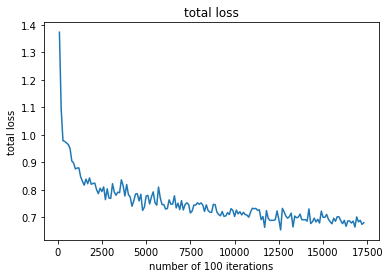

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(idx,trainloss)
plt.xlabel('number of 100 iterations')
plt.ylabel('total loss')
plt.title('total loss')

Text(0.5, 1.0, 'classifier loss')

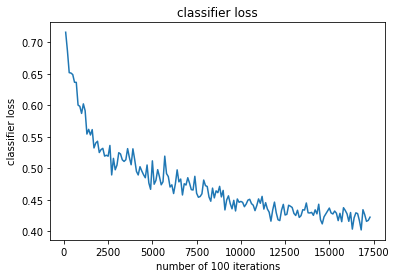

In [ ]:
plt.plot(idx,classifierloss)
plt.xlabel('number of 100 iterations')
plt.ylabel('classifier loss')
plt.title('classifier loss')

Text(0.5, 1.0, 'regressor loss')

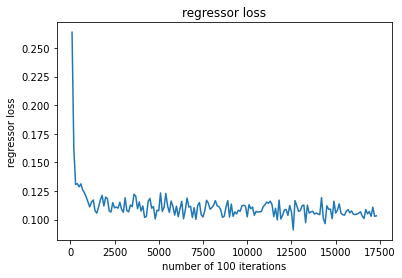

In [ ]:
plt.plot(idx,regressorloss)
plt.xlabel('number of 100 iterations')
plt.ylabel('regressor loss')
plt.title('regressor loss')

##Validation

In [ ]:
rpn = RPN()
val_tot_loss = []
val_cls_loss = []
val_reg_loss = []
val_idx = []
for i in range(26):
  print(i)
  checkpoint = torch.load('/content/drive/My Drive/CIS680_2019/rpn_epoch'+str(i))
  rpn.load_state_dict(checkpoint['model_state_dict'])
  rpn = rpn.to(device)
  Tot_loss = 0
  Cls_loss = 0
  Reg_loss = 0
  rpn.eval()
  for iter,data in enumerate(test_loader):
    img,_,_,_,index = [data[i] for i in range(len(data))]
    index = torch.tensor(index).view(-1)
    target_obj=anchor_labels[index].to(device)
    target_bbox=anchor_gt_bboxes_p[index].to(device)
    img_batch = [i.unsqueeze(0) for i in img]
    img_batch = torch.cat(img_batch)
    img_batch = img_batch.squeeze(1).float().to(device)
    out_obj,out_bbox = rpn(img_batch)
    class_loss,reg_loss,total_loss_norm=Loss(out_obj,out_bbox,target_obj,target_bbox)
    Tot_loss += total_loss_norm.item()
    Reg_loss += reg_loss.item()
    Cls_loss += class_loss.item()
  Total_loss = Tot_loss/len(test_loader)
  Regrsor_loss = Reg_loss/len(test_loader)
  Class_loss = Cls_loss/len(test_loader)
  val_tot_loss.append(Total_loss)
  val_cls_loss.append(Class_loss)
  val_reg_loss.append(Regrsor_loss)
  val_idx.append(i)
  



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


Text(0.5, 1.0, 'Validation total loss')

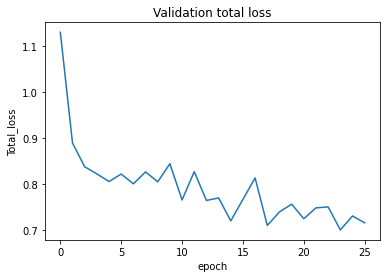

In [ ]:
plt.plot(val_idx,val_tot_loss)
plt.xlabel("epoch")
plt.ylabel("Total_loss")
plt.title("Validation total loss")

Text(0.5, 1.0, 'Validation Classifier loss')

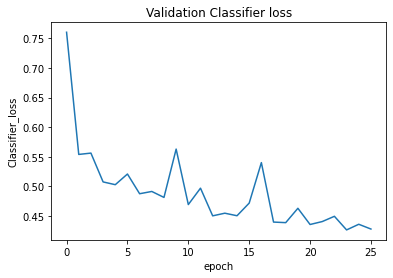

In [ ]:
plt.plot(val_idx,val_cls_loss)
plt.xlabel("epoch")
plt.ylabel("Classifier_loss")
plt.title("Validation Classifier loss")

Text(0.5, 1.0, 'Validation Regressor loss')

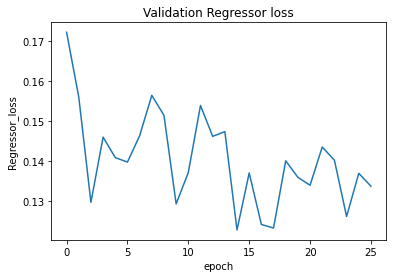

In [ ]:
plt.plot(val_idx,val_reg_loss)
plt.xlabel("epoch")
plt.ylabel("Regressor_loss")
plt.title("Validation Regressor loss")

### **POINT  WISE ACCURACY**

In [ ]:

def point_accuracy(gt_anchor_labels, pred_anchor_labels):
  count=0
  p_accuracy=0.0
  for i in range(50):
    for j in range(68):
      if (pred_anchor_labels[i][j]>=0.5 and gt_anchor_labels[i][j]==1):
        count+=1
      elif (pred_anchor_labels[i][j]<=0.5 and gt_anchor_labels[i][j]==0):
        count+=1
      elif (pred_anchor_labels[i][j]<=0.5 and gt_anchor_labels[i][j]==-1):
        count+=1
  p_accuracy=count/(50*68)    
  return p_accuracy

In [ ]:
rpn=RPN()
device = torch.device("cuda")## initilize device to cpu or cuda
rpn=rpn.to(device)

learning_rate = 10e-5

## intialize optimizer
optimizer=torch.optim.Adam(rpn.parameters(),lr=learning_rate,weight_decay=0.0001)
path='/content/drive/My Drive/RPN models/rpn_epoch17'
checkpoint = torch.load(path)
rpn.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

In [ ]:
idx=0
pointwise_sum=0
rpn=rpn.to(device)
with torch.no_grad():
  rpn.eval()
  for iter, data in enumerate(test_loader, 0):
    img, label, mask, bbox,index = [data[i] for i in range(len(data))]
    image_batch=img[0].float()
    image_batch=image_batch.to(device)
    out_obj,out_bbox = rpn(image_batch)
    target_obj=anchor_labels[index[0]]
   
    out_obj=out_obj.squeeze(0).squeeze(0)
    pointwise_sum+=point_accuracy(target_obj,out_obj)
    idx+=1
avg_pointwise_accuracy=pointwise_sum/idx
print(avg_pointwise_accuracy)

0.7327402936672368


**PLOTTING TOP 20 PROPOSALS**

In [ ]:
with torch.no_grad():
  rpn.eval()
  for iter, data in enumerate(test_loader, 0):
    img, label, mask, bbox,index = [data[i] for i in range(len(data))]
    image_batch=img[0]
    out_obj,out_bbox = rpn(image_batch)
    target_obj=anchor_labels[index[0]]
    target_bbox=anchor_gt_bboxes_p[index[0]]
    anchors=anchors_all[index[0]]
    break

In [ ]:
plt.figure()
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))

temp_out_obj=out_obj
maximum=0

for i in range(50):
  for j in range(68):
    if (out_obj[i][j])

for j in range(50):
  for k in range(68):
    if (out_obj[j][k])==1:
      rect1 = patches.Rectangle((anchors[j][k][0],anchors[j][k][1]),(anchors[j][k][2]-anchors[j][k][0]),(anchors[j][k][3]-anchors[j][k][1]),linewidth=1,edgecolor='b',facecolor='none')
      ax.add_patch(rect1)

plt.show()

<Figure size 432x288 with 0 Axes>

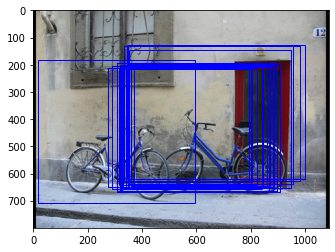

In [ ]:
with torch.no_grad():
  rpn.eval()
  for iter, data in enumerate(test_loader, 0):
    img, label, mask, bbox,index = [data[i] for i in range(len(data))]
    image_batch=img[0].float()
    image_batch=image_batch.to(device)
    out_obj,out_bbox = rpn(image_batch)
    target_obj=anchor_labels[index[0]]
    target_bbox=anchor_gt_bboxes[index[0]]
    target_anchor=anchors_all[index[0]]
    target_bbox_p=anchor_gt_bboxes_p[index[0]]
    out_obj=out_obj.squeeze(0).squeeze(0)
    out_bbox_perm=out_bbox.permute(0,2,3,1).squeeze(0)
   
    break
plt.figure()
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))

temp_out_obj=out_obj
maximum=0

for k in range(20):
  maximum=torch.max(temp_out_obj)
  for i in range(50):
    for j in range(68):
      if (temp_out_obj[i][j]==maximum):
        x_c=(out_bbox_perm[i][j][0])*230+target_anchor[i][j][0]
       
        y_c=(out_bbox_perm[i][j][1])*286+target_anchor[i][j][1]
        w=torch.exp(out_bbox_perm[i][j][2])*230
        h=torch.exp(out_bbox_perm[i][j][3])*286
       
        x1=x_c-w/2
        y1=y_c-h/2

        rect1 = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect1)  
        temp_out_obj[i][j]=torch.min(temp_out_obj)

plt.show()

### **PROPOSED BOXES (PRE NMS)**

<Figure size 432x288 with 0 Axes>

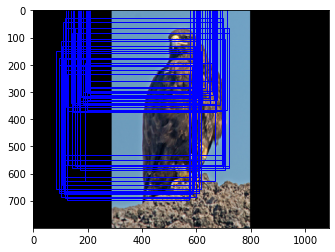

In [ ]:
with torch.no_grad():
  rpn.eval()
  for iter, data in enumerate(test_loader, 0):
    img, label, mask, bbox,index = [data[i] for i in range(len(data))]
    image_batch=img[0].float()
    image_batch=image_batch.to(device)
    out_obj,out_bbox = rpn(image_batch)
    target_obj=anchor_labels[index[0]]
    target_bbox=anchor_gt_bboxes[index[0]]
    target_anchor=anchors_all[index[0]]
    target_bbox_p=anchor_gt_bboxes_p[index[0]]
    out_obj=out_obj.squeeze(0).squeeze(0)
    out_bbox_perm=out_bbox.permute(0,2,3,1).squeeze(0)
   
    break
plt.figure()
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))

temp_out_obj=out_obj
maximum=0

for k in range(50):
  maximum=torch.max(temp_out_obj)
  for i in range(50):
    for j in range(68):
      if (temp_out_obj[i][j]==maximum):
        x_c=(out_bbox_perm[i][j][0])*230+target_anchor[i][j][0]
       
        y_c=(out_bbox_perm[i][j][1])*286+target_anchor[i][j][1]
        # w_b=torch.exp(out_bbox_perm[i][j][2])*230
        # h_b=torch.exp(out_bbox_perm[i][j][3])*286
        w=torch.exp(out_bbox_perm[i][j][2])*230
        h=torch.exp(out_bbox_perm[i][j][3])*286
       
        x1=x_c-w/2
        y1=y_c-h/2

        rect1 = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect1)  
        temp_out_obj[i][j]=torch.min(temp_out_obj)

plt.show()

### **POST NMS**

In [ ]:
def IOU(bbox_1 ,bbox_2):
  x_1up=bbox_1[0]
  y_1up=bbox_1[1]
  x_1l=bbox_1[2]
  y_1l=bbox_1[3]

  x_2up=bbox_2[0]
  y_2up=bbox_2[1]
  x_2l=bbox_2[2]
  y_2l=bbox_2[3]

 
  x_up=max(x_1up,x_2up)
  y_up=max(y_1up,y_2up)
  x_l=min(x_1l,x_2l)
  y_l=min(y_1l,y_2l)

  inter_area=max((x_l-x_up+1),0)*max((y_l-y_up+1),0)
  area_box1=(x_1l-x_1up+1)*(y_1l-y_1up+1)
  area_box2=(x_2l-x_2up+1)*(y_2l-y_2up+1)
  union_area=area_box1+area_box2-inter_area
  iou=inter_area/float(union_area)
  return iou

<Figure size 432x288 with 0 Axes>

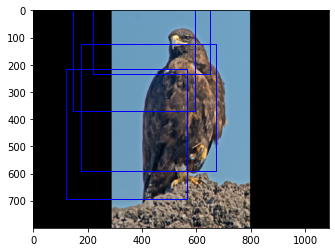

In [ ]:
temp_out_obj=out_obj
maximum=0
fifty= torch.zeros(50,4)
fifty_obj = torch.zeros(50,1)
for k in range(50):
  maximum=torch.max(temp_out_obj)
  for i in range(50):
    for j in range(68):
      if (temp_out_obj[i][j]==maximum):
        x_c=(out_bbox_perm[i][j][0])*230+target_anchor[i][j][0]
       
        y_c=(out_bbox_perm[i][j][1])*286+target_anchor[i][j][1]
        # w_b=torch.exp(out_bbox_perm[i][j][2])*230
        # h_b=torch.exp(out_bbox_perm[i][j][3])*286
        w=torch.exp(out_bbox_perm[i][j][2])*230
        h=torch.exp(out_bbox_perm[i][j][3])*286
       
        x1=x_c-w/2
        y1=y_c-h/2
        x2=x_c+w/2
        y2=y_c+h/2
        fifty[k][0]=x1
        fifty[k][1]=y1
        fifty[k][2]=x2
        fifty[k][3]=y2
        fifty_obj[k]=temp_out_obj[i][j]
        temp_out_obj[i][j]=torch.min(temp_out_obj)
for i in range(50):
    bb1= fifty[i]
    for j in range(50):
        bb2=fifty[j]
        if (i!=j):
          iou= IOU (bb1, bb2)
          if iou > 0.5:
            if fifty_obj[i]>fifty_obj[j]:
              fifty_obj[j]=0
            elif fifty_obj[i]<fifty_obj[j]:
              fifty_obj[i]=0
plt.figure()
fig,ax = plt.subplots(1)
opp_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
img_plot = opp_transform(img[0].squeeze(0))
plt.imshow(img_plot.numpy().transpose((1,2,0)).astype('long'))
iter=0
for i in range(50):
  if fifty_obj[i]>0:
    iter+=1
    rect1 = patches.Rectangle((fifty[i][0],fifty[i][1]),(fifty[i][2]-fifty[i][0]),(fifty[i][3]-fifty[i][1]),linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect1)
    if iter==5:
      break
plt.show()